### Complete TensorFlow mixed-precision implementation with Bert

*1.use bert in tensorflow 2.1*
*2.add the sentiment frquence: positive negative neutral*
*3.use lr warmup*
*4. focal loss*
*5.get the best logits*

In [1]:
import numpy as np
import pandas as pd
from math import ceil, floor
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.layers as L
from tensorflow.keras.initializers import TruncatedNormal
from sklearn import model_selection
from transformers import BertConfig, TFBertPreTrainedModel, TFBertMainLayer
from transformers import RobertaConfig, TFRobertaPreTrainedModel, TFRobertaMainLayer, TFRobertaModel
from tokenizers import BertWordPieceTokenizer, ByteLevelBPETokenizer
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import os
import re
from transformers.modeling_tf_roberta import TFRobertaEmbeddings
from transformers.tokenization_utils import BatchEncoding
from transformers.modeling_tf_utils import shape_list

import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
    
# tf.config.optimizer.set_jit(True)
# tf.config.optimizer.set_experimental_options(
#     {"auto_mixed_precision": True})

In [2]:
# read csv files
train_df = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
train_df.dropna(inplace=True)

test_df = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')
test_df.loc[:, "selected_text"] = test_df.text.values

submission_df = pd.read_csv('../input/tweet-sentiment-extraction/sample_submission.csv')

print("train shape =", train_df.shape)
print("test shape  =", test_df.shape)

# set some global variables
PATH = "../input/tf-roberta/"
MAX_SEQUENCE_LENGTH = 96
# TOKENIZER = BertWordPieceTokenizer(f"../input/bert-base-uncased/vocab.txt", lowercase=True, add_special_tokens=False)
TOKENIZER = ByteLevelBPETokenizer(vocab_file=f"{PATH}/vocab-roberta-base.json", 
                                  merges_file=f"{PATH}/merges-roberta-base.txt", 
                                  lowercase=True, 
                                  add_prefix_space=True)

sentiment_dict = {"positive": ["good", "happy", "love", "day", "thanks", "great", "fun", "nice", "hope", "thank"],
                  "negative": ["miss", "sad", "sorry", "bad", "hate", "sucks", "sick", "like", "feel", "bored"],
                  "neutral": ["get", "go", "day", "work", "going", "quot", "lol", "got", "like", "today"]}

# let's take a look at the data
train_df.head(10)


train shape = (27480, 4)
test shape  = (3534, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


```
I. Set up preprocessing and dataset/datagenerator
```


In [3]:
def preprocess(tweet, selected_text, sentiment):
    """
    Will be used in tf.data.Dataset.from_generator(...)

    """
    
    # The original strings have been converted to
    # byte strings, so we need to decode it
    tweet = tweet.decode('utf-8')
    selected_text = selected_text.decode('utf-8')
    sentiment = sentiment.decode('utf-8')
    
    tweet = " " + " ".join(str(tweet).split())
    selected_text = " " + " ".join(str(selected_text).split())

    len_st = len(selected_text) - 1
    idx0 = None
    idx1 = None

    for ind in (i for i, e in enumerate(tweet) if e == selected_text[1]):
        if " " + tweet[ind: ind+len_st] == selected_text:
            idx0 = ind
            idx1 = ind + len_st - 1
            break

    char_targets = [0] * len(tweet)
    if idx0 != None and idx1 != None:
        for ct in range(idx0, idx1 + 1):
            char_targets[ct] = 1
    
    # tokenize with offsets
    enc = TOKENIZER.encode(tweet)
    input_ids_orig = enc.ids
    offsets = enc.offsets
    
    target_idx = []
    for j, (offset1, offset2) in enumerate(offsets):
        if sum(char_targets[offset1: offset2]) > 0:
            target_idx.append(j)

    target_start = target_idx[0]
    target_end = target_idx[-1]
    
    # add sentiment word frequency
    sentiment_frequency = []
    pos_fre = 0
    neg_fre = 0
    neu_fre = 0
    for token in enc.tokens:
        token = token.replace("Ġ", "")
        if token in sentiment_dict["positive"]:
            pos_fre += 1
        if token in sentiment_dict["negative"]:
            neg_fre += 1
        if token in sentiment_dict["neutral"]:
            neu_fre += 1
    sentiment_frequency.append(str(pos_fre))
    sentiment_frequency.append(str(neg_fre))
    sentiment_frequency.append(str(neu_fre))
    enc_sentiment = TOKENIZER.encode(" ".join(sentiment_frequency))
    
    
    # add and pad data (hardcoded for BERT)
    # --> [CLS] sentiment [SEP] input_ids [SEP] [PAD]
    sentiment_map = {
        'positive': 1313,
        'negative': 2430,
        'neutral': 7974
    }

    input_ids = [0] + input_ids_orig + [2] + [2] + [sentiment_map[sentiment]] + enc_sentiment.ids + [2]
    input_type_ids = [0] * 1 + [0] * (len(input_ids_orig) + 7)
    attention_mask = [1] * (len(input_ids_orig) + 8)
    offsets = [(0, 0)] + offsets + [(0, 0)] * 7
    target_start += pos_offsets
    target_end += pos_offsets

    padding_length = MAX_SEQUENCE_LENGTH - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([1] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)
        input_type_ids = input_type_ids + ([0] * padding_length)
        offsets = offsets + ([(0, 0)] * padding_length)
    elif padding_length < 0:
        input_ids = input_ids[:padding_length - 1] + [2]
        attention_mask = attention_mask[:padding_length - 1] + [1]
        input_type_ids = input_type_ids[:padding_length - 1] + [0]
        offsets = offsets[:padding_length - 1] + [(0, 0)]
        if target_start >= MAX_SEQUENCE_LENGTH:
            target_start = MAX_SEQUENCE_LENGTH - 1
        if target_end >= MAX_SEQUENCE_LENGTH:
            target_end = MAX_SEQUENCE_LENGTH - 1

    return (
        input_ids, attention_mask, input_type_ids, offsets,
        target_start, target_end, tweet, selected_text, sentiment,
    )

class TweetSentimentDataset(tf.data.Dataset):
    
    OUTPUT_TYPES = (
        tf.dtypes.int32,  tf.dtypes.int32,   tf.dtypes.int32, 
        tf.dtypes.int32,  tf.dtypes.float32, tf.dtypes.float32,
        tf.dtypes.string, tf.dtypes.string,  tf.dtypes.string,
    )
    
    OUTPUT_SHAPES = (
        (MAX_SEQUENCE_LENGTH,),   (MAX_SEQUENCE_LENGTH,), (MAX_SEQUENCE_LENGTH,), 
        (MAX_SEQUENCE_LENGTH, 2), (),                     (),
        (),                       (),                     (),
    )
    
    # AutoGraph will automatically convert Python code to
    # Tensorflow graph code. You could also wrap 'preprocess' 
    # in tf.py_function(..) for arbitrary python code
    def _generator(tweet, selected_text, sentiment):
        for tw, st, se in zip(tweet, selected_text, sentiment):
            yield preprocess(tw, st, se)
    
    # This dataset object will return a generator
    def __new__(cls, tweet, selected_text, sentiment):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(tweet, selected_text, sentiment)
        )
    
    @staticmethod
    def create(dataframe, batch_size, shuffle_buffer_size=-1):
        dataset = TweetSentimentDataset(
            dataframe.text.values, 
            dataframe.selected_text.values, 
            dataframe.sentiment.values
        )

        dataset = dataset.cache()
        if shuffle_buffer_size != -1:
            dataset = dataset.shuffle(shuffle_buffer_size)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        # d = next(iter(dataset))
        # print("Writing example in %d" % (len(dataframe)))
        # for i in range(5):
        #     print("*** Example ***")
        #     print("tokens: %s" % " ".join(TOKENIZER.encode(d[6].numpy()[i].decode("utf-8")).tokens))
        #     print("input_ids: %s" % " ".join([str(x) for x in d[0].numpy()[i]]))
        #     print("input_mask: %s" % " ".join([str(x) for x in d[1].numpy()[i]]))
        #     print("segment_ids: %s" % " ".join([str(x) for x in d[2].numpy()[i]]))
        #     print("selected_text: %s" % d[7].numpy()[i].decode("utf-8"))
        #     print("idx_start: %d" % d[4].numpy()[i])
        #     print("idx_end: %d" % d[5].numpy()[i])
        
        return dataset
        
def generate_fold_data(data, num_folds):
    kfold = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold_num, (train_idx, valid_idx) in enumerate(kfold.split(X=data.text, y=data.sentiment.values)):
        if fold_num == 0:
            save_data = data.iloc[valid_idx]
            save_data["kfold"] = fold_num
        else:
            _save_data = data.iloc[valid_idx]
            _save_data["kfold"] = fold_num
            save_data = pd.concat([save_data, _save_data], axis=0)
            
    save_data = save_data.reset_index(drop=True)
    # print(save_data.shape)
    # save_data.to_csv("train_5folds.csv", index=False)
    return save_data

In [4]:
def post_process(s):
    a = re.findall('[^A-Za-z0-9]',s)
    b = re.sub('[^A-Za-z0-9]+', '', s)

    try:
        if a.count('.')==3:
            text = b + '. ' + b + '..'
        elif a.count('!')==4:
            text = b + '! ' + b + '!! ' +  b + '!!!'
        else:
            text = s
        return text
    except:
        return text


```
II. Set up transformer model and functions
```

In [5]:
class TFRobertaMainLayer1(TFBertMainLayer):
    """
    Same as TFBertMainLayer but uses TFRobertaEmbeddings.
    """

    def __init__(self, config, **kwargs):
        super().__init__(config, **kwargs)
        self.embeddings = TFRobertaEmbeddings(config, name="embeddings")

    def get_input_embeddings(self):
        return self.embeddings

    def _resize_token_embeddings(self, new_num_tokens):
        raise NotImplementedError

    def _prune_heads(self, heads_to_prune):
        """ Prunes heads of the model.
            heads_to_prune: dict of {layer_num: list of heads to prune in this layer}
            See base class PreTrainedModel
        """
        raise NotImplementedError

    def call(
            self,
            inputs,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            training=False,
    ):
        if isinstance(inputs, (tuple, list)):
            input_ids = inputs[0]
            attention_mask = inputs[1] if len(inputs) > 1 else attention_mask
            token_type_ids = inputs[2] if len(inputs) > 2 else token_type_ids
            position_ids = inputs[3] if len(inputs) > 3 else position_ids
            head_mask = inputs[4] if len(inputs) > 4 else head_mask
            inputs_embeds = inputs[5] if len(inputs) > 5 else inputs_embeds
            assert len(inputs) <= 6, "Too many inputs."
        elif isinstance(inputs, (dict, BatchEncoding)):
            input_ids = inputs.get("input_ids")
            attention_mask = inputs.get("attention_mask", attention_mask)
            token_type_ids = inputs.get("token_type_ids", token_type_ids)
            position_ids = inputs.get("position_ids", position_ids)
            head_mask = inputs.get("head_mask", head_mask)
            inputs_embeds = inputs.get("inputs_embeds", inputs_embeds)
            assert len(inputs) <= 6, "Too many inputs."
        else:
            input_ids = inputs

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = shape_list(input_ids)
        elif inputs_embeds is not None:
            input_shape = shape_list(inputs_embeds)[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if attention_mask is None:
            attention_mask = tf.fill(input_shape, 1)
        if token_type_ids is None:
            token_type_ids = tf.fill(input_shape, 0)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask[:, tf.newaxis, tf.newaxis, :]

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.

        extended_attention_mask = tf.cast(extended_attention_mask, tf.float32)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        if head_mask is not None:
            raise NotImplementedError
        else:
            head_mask = [None] * self.num_hidden_layers
            # head_mask = tf.constant([0] * self.num_hidden_layers)

        embedding_output = self.embeddings([input_ids, position_ids, token_type_ids, inputs_embeds], training=training)
        return embedding_output, extended_attention_mask, head_mask

    def call_run(self, embedding_output, extended_attention_mask, head_mask, training):
        encoder_outputs = self.encoder([embedding_output, extended_attention_mask, head_mask], training=training)
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)

        # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]  # add hidden_states and attentions if they are here

        return outputs


class RoBertQAModel1(TFRobertaPreTrainedModel):

    DROPOUT_RATE = 0.3
    NUM_HIDDEN_STATES = 2

    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)

        self.robert = TFRobertaMainLayer1(config, name="roberta")

        self.dropout = L.Dropout(self.DROPOUT_RATE)
        self.conv1d_128 = L.Conv1D(128, 2, padding='same')
        self.conv1d_64 = L.Conv1D(64, 2, padding='same')
        self.leakyreLU = L.LeakyReLU()
        self.dense = L.Dense(1, dtype='float32')
        self.flatten = L.Flatten()

        self.dropout_2 = L.Dropout(self.DROPOUT_RATE)
        self.conv1d_128_2 = L.Conv1D(128, 2, padding='same')
        self.conv1d_64_2 = L.Conv1D(64, 2, padding='same')
        self.leakyreLU_2 = L.LeakyReLU()
        self.dense_2 = L.Dense(1, dtype='float32')
        self.flatten_2 = L.Flatten()

    @tf.function
    def call(self, inputs, **kwargs):

        embedding_output, extended_attention_mask, head_mask = self.robert(inputs, **kwargs)
        # _, _, hidden_states = self.robert.call_run(embedding_output, extended_attention_mask, head_mask, training=kwargs.get("training", False))
        
        y_pred = self.call_run(embedding_output, extended_attention_mask, head_mask, training=kwargs.get("training", False))
        return embedding_output, extended_attention_mask, head_mask, y_pred
    
    @tf.function
    def call_run(self, embedding_output, extended_attention_mask, head_mask, training):
        _, _, hidden_states = self.robert.call_run(embedding_output, extended_attention_mask, head_mask, training=training)

        x1 = self.dropout(hidden_states[-1], training=training)
        x1 = self.conv1d_128(x1)
        x1 = self.leakyreLU(x1)
        x1 = self.conv1d_64(x1)
        x1 = self.dense(x1)
        x1 = self.flatten(x1)
        start_logits = L.Activation('softmax')(x1)

        x2 = self.dropout_2(hidden_states[-2], training=training)
        x2 = self.conv1d_128_2(x2)
        x2 = self.leakyreLU_2(x2)
        x2 = self.conv1d_64_2(x2)
        x2 = self.dense_2(x2)
        x2 = self.flatten_2(x2)
        end_logits = L.Activation('softmax')(x2)
        return x1, x2
    
    @tf.function
    def adversarial(self, x1, extended_attention_mask, head_mask, y_true, loss_fn):
        """
        Adversarial training
        """
        y_pred = self.call_run(x1, extended_attention_mask, head_mask, training=True)
        loss  = (loss_fn(y_true[0], y_pred[0]) + loss_fn(y_true[1], y_pred[1])) / 2
        perturb = tf.gradients(loss, x1, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_ACCUMULATE_N)[0]
        
        #reciprocal in l2 normal
        perturb = 0.02 * tf.math.l2_normalize(tf.stop_gradient(perturb), axis=1)
        x1 = x1 + perturb        
        
        # adv_loss
        y_pred = self.call_run(x1, extended_attention_mask, head_mask, training=True)
        adv_loss  = loss_fn(y_true[0], y_pred[0]) + loss_fn(y_true[1], y_pred[1])
        return adv_loss
    
    @tf.function
    def virtual_adversarial(self, x1, extended_attention_mask, head_mask, y_pred, power_iterations=1, p_mult=0.02):
        bernoulli = tfp.distributions.Bernoulli
        # y_pred = self.call_run(x1, extended_attention_mask, head_mask, training=True)
        prob1 = tf.clip_by_value((y_pred[0] + y_pred[1]) / 2, 1e-7, 1. - 1e-7)
        prob_dist1 = bernoulli(probs=prob1)
        # prob2 = tf.clip_by_value(y_pred[1], 1e-7, 1. - 1e-7)
        # prob_dist2 = bernoulli(probs=prob2)

        # generate virtual adversarial perturbation
        d1 = tf.keras.backend.random_uniform(shape=tf.shape(x1), dtype=tf.dtypes.float32)
        # d2 = tf.keras.backend.random_uniform(shape=tf.shape(x1), dtype=tf.dtypes.float32)
        for _ in range(power_iterations):
            d1 = (0.02) * tf.math.l2_normalize(d1, axis=1)
            # d2 = (0.02) * tf.math.l2_normalize(d2, axis=1)
            y_pred1 = self.call_run(x1 + d1, extended_attention_mask, head_mask, training=True)
            # y_pred2 = self.call_run(x1 + d2 , extended_attention_mask, head_mask, training=True)
            p_prob1 = tf.clip_by_value((y_pred1[0] + y_pred1[1]) / 2, 1e-7, 1. - 1e-7)
            # p_prob2 = tf.clip_by_value(y_pred1[1], 1e-7, 1. - 1e-7)
            kl1 = tfp.distributions.kl_divergence(prob_dist1, bernoulli(probs=p_prob1), allow_nan_stats=False)
            # kl2 = tfp.distributions.kl_divergence(prob_dist2, bernoulli(probs=p_prob2), allow_nan_stats=False)

            gradient1 = tf.gradients(kl1, [d1], aggregation_method=tf.AggregationMethod.EXPERIMENTAL_ACCUMULATE_N)[0]
            # gradient2 = tf.gradients(kl2, [d2], aggregation_method=tf.AggregationMethod.EXPERIMENTAL_ACCUMULATE_N)[0]
            d1 = tf.stop_gradient(gradient1)
            # d2 = tf.stop_gradient(gradient2)
        d1 = p_mult * tf.math.l2_normalize(d1, axis=1)
        # d2 = p_mult * tf.math.l2_normalize(d2, axis=1)
        tf.stop_gradient(prob1)
        # tf.stop_gradient(prob2)

        # virtual adversarial loss
        y_pred1 = self.call_run(x1 + d1, extended_attention_mask, head_mask, training=True)
        # y_pred2 = self.call_run(x1 + d2 , extended_attention_mask, head_mask, training=True)
        p_prob1 = tf.clip_by_value((y_pred1[0] + y_pred1[1]) / 2, 1e-7, 1. - 1e-7)
        # p_prob2 = tf.clip_by_value(y_pred1[1], 1e-7, 1. - 1e-7)
        v_adv_loss1 = tfp.distributions.kl_divergence(prob_dist1, bernoulli(probs=p_prob1), allow_nan_stats=False)
        # v_adv_loss2 = tfp.distributions.kl_divergence(prob_dist2, bernoulli(probs=p_prob2), allow_nan_stats=False)
        return tf.reduce_mean(v_adv_loss1)
    
class RoBertQAModel2(TFRobertaPreTrainedModel):
    
    DROPOUT_RATE = 0.2
    NUM_HIDDEN_STATES = 2
    
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        
        self.bert = TFRobertaMainLayer(config, name="bert")
        self.concat = L.Concatenate()
        self.dropout = L.Dropout(self.DROPOUT_RATE)
        self.qa_outputs = L.Dense(
            config.num_labels, 
            kernel_initializer=TruncatedNormal(stddev=config.initializer_range),
            dtype='float32',
            name="qa_outputs")
        self.conv1d_128 = L.Conv1D(128, 2, padding='same')
        self.conv1d_64 = L.Conv1D(64, 2, padding='same')
        self.leakyreLU = L.LeakyReLU()
        self.dense = L.Dense(1, dtype='float32')
        self.flatten = L.Flatten()
        
        self.dropout_2 = L.Dropout(self.DROPOUT_RATE)
        self.conv1d_128_2 = L.Conv1D(128, 2, padding='same')
        self.conv1d_64_2 = L.Conv1D(64, 2, padding='same')
        self.leakyreLU_2 = L.LeakyReLU()
        self.dense_2 = L.Dense(1, dtype='float32')
        self.flatten_2 = L.Flatten()
        
        
    @tf.function
    def call(self, inputs, **kwargs):
        # outputs: Tuple[sequence, pooled, hidden_states]
        x, _, hidden_states = self.bert(inputs, **kwargs)
        
        x1 = self.dropout(hidden_states[-1], training=kwargs.get("training", False))
        x1 = self.conv1d_128(x1)
        x1 = self.leakyreLU(x1)
        x1 = self.conv1d_64(x1)
        x1 = self.dense(x1)
        x1 = self.flatten(x1)
        start_logits = tf.keras.layers.Activation('softmax')(x1)
        
        x2 = self.dropout_2(hidden_states[-2], training=kwargs.get("training", False))
        x2 = self.conv1d_128_2(x2)
        x2 = self.leakyreLU_2(x2)
        x2 = self.conv1d_64_2(x2)
        x2 = self.dense_2(x2)
        x2 = self.flatten_2(x2)
        end_logits = tf.keras.layers.Activation('softmax')(x2)
    
        return x1, x2

class RoBertQAModel3(TFRobertaPreTrainedModel):

    DROPOUT_RATE = 0.3
    NUM_HIDDEN_STATES = 2

    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)

        self.robert = TFRobertaMainLayer1(config, name="roberta")

        self.dropout = L.Dropout(self.DROPOUT_RATE)
        self.conv1d_128 = L.Conv1D(128, 2, padding='same')
        self.conv1d_64 = L.Conv1D(64, 2, padding='same')
        self.leakyreLU = L.LeakyReLU()
        self.dense = L.Dense(1, dtype='float32')
        self.flatten = L.Flatten()

        self.dropout_2 = L.Dropout(self.DROPOUT_RATE)
        self.conv1d_128_2 = L.Conv1D(128, 2, padding='same')
        self.conv1d_64_2 = L.Conv1D(64, 2, padding='same')
        self.leakyreLU_2 = L.LeakyReLU()
        self.dense_2 = L.Dense(1, dtype='float32')
        self.flatten_2 = L.Flatten()

    @tf.function
    def call(self, inputs, **kwargs):

        embedding_output, extended_attention_mask, head_mask = self.robert(inputs, **kwargs)
        # _, _, hidden_states = self.robert.call_run(embedding_output, extended_attention_mask, head_mask, training=kwargs.get("training", False))
        
        y_pred = self.call_run(embedding_output, extended_attention_mask, head_mask, training=kwargs.get("training", False))
        return embedding_output, extended_attention_mask, head_mask, y_pred
    
    @tf.function
    def call_run(self, embedding_output, extended_attention_mask, head_mask, training):
        _, _, hidden_states = self.robert.call_run(embedding_output, extended_attention_mask, head_mask, training=training)

        x1 = self.dropout(hidden_states[-1], training=training)
        x1 = self.conv1d_128(x1)
        x1 = self.leakyreLU(x1)
        x1 = self.conv1d_64(x1)
        x1 = self.dense(x1)
        x1 = self.flatten(x1)
        start_logits = L.Activation('softmax')(x1)

        x2 = self.dropout_2(hidden_states[-2], training=training)
        x2 = self.conv1d_128_2(x2)
        x2 = self.leakyreLU_2(x2)
        x2 = self.conv1d_64_2(x2)
        x2 = self.dense_2(x2)
        x2 = self.flatten_2(x2)
        end_logits = L.Activation('softmax')(x2)
        return x1, x2
    
    @tf.function
    def adversarial(self, x1, extended_attention_mask, head_mask, y_true, loss_fn):
        """
        Adversarial training
        """
        y_pred = self.call_run(x1, extended_attention_mask, head_mask, training=True)
        loss  = (loss_fn(y_true[0], y_pred[0]) + loss_fn(y_true[1], y_pred[1])) / 2
        perturb = tf.gradients(loss, x1, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_ACCUMULATE_N)[0]
        
        #reciprocal in l2 normal
        perturb = 0.02 * tf.math.l2_normalize(tf.stop_gradient(perturb), axis=1)
        x1 = x1 + perturb        
        
        # adv_loss
        y_pred = self.call_run(x1, extended_attention_mask, head_mask, training=True)
        adv_loss  = loss_fn(y_true[0], y_pred[0]) + loss_fn(y_true[1], y_pred[1])
        return adv_loss
    
    @tf.function
    def virtual_adversarial(self, x1, extended_attention_mask, head_mask, y_pred, power_iterations=1, p_mult=0.02):
        bernoulli = tfp.distributions.Bernoulli
        # y_pred = self.call_run(x1, extended_attention_mask, head_mask, training=True)
        prob1 = tf.clip_by_value((y_pred[0] + y_pred[1]) / 2, 1e-7, 1. - 1e-7)
        prob_dist1 = bernoulli(probs=prob1)
        # prob2 = tf.clip_by_value(y_pred[1], 1e-7, 1. - 1e-7)
        # prob_dist2 = bernoulli(probs=prob2)

        # generate virtual adversarial perturbation
        d1 = tf.keras.backend.random_uniform(shape=tf.shape(x1), dtype=tf.dtypes.float32)
        # d2 = tf.keras.backend.random_uniform(shape=tf.shape(x1), dtype=tf.dtypes.float32)
        for _ in range(power_iterations):
            d1 = (0.02) * tf.math.l2_normalize(d1, axis=1)
            # d2 = (0.02) * tf.math.l2_normalize(d2, axis=1)
            y_pred1 = self.call_run(x1 + d1, extended_attention_mask, head_mask, training=True)
            # y_pred2 = self.call_run(x1 + d2 , extended_attention_mask, head_mask, training=True)
            p_prob1 = tf.clip_by_value((y_pred1[0] + y_pred1[1]) / 2, 1e-7, 1. - 1e-7)
            # p_prob2 = tf.clip_by_value(y_pred1[1], 1e-7, 1. - 1e-7)
            kl1 = tfp.distributions.kl_divergence(prob_dist1, bernoulli(probs=p_prob1), allow_nan_stats=False)
            # kl2 = tfp.distributions.kl_divergence(prob_dist2, bernoulli(probs=p_prob2), allow_nan_stats=False)

            gradient1 = tf.gradients(kl1, [d1], aggregation_method=tf.AggregationMethod.EXPERIMENTAL_ACCUMULATE_N)[0]
            # gradient2 = tf.gradients(kl2, [d2], aggregation_method=tf.AggregationMethod.EXPERIMENTAL_ACCUMULATE_N)[0]
            d1 = tf.stop_gradient(gradient1)
            # d2 = tf.stop_gradient(gradient2)
        d1 = p_mult * tf.math.l2_normalize(d1, axis=1)
        # d2 = p_mult * tf.math.l2_normalize(d2, axis=1)
        tf.stop_gradient(prob1)
        # tf.stop_gradient(prob2)

        # virtual adversarial loss
        y_pred1 = self.call_run(x1 + d1, extended_attention_mask, head_mask, training=True)
        # y_pred2 = self.call_run(x1 + d2 , extended_attention_mask, head_mask, training=True)
        p_prob1 = tf.clip_by_value((y_pred1[0] + y_pred1[1]) / 2, 1e-7, 1. - 1e-7)
        # p_prob2 = tf.clip_by_value(y_pred1[1], 1e-7, 1. - 1e-7)
        v_adv_loss1 = tfp.distributions.kl_divergence(prob_dist1, bernoulli(probs=p_prob1), allow_nan_stats=False)
        # v_adv_loss2 = tfp.distributions.kl_divergence(prob_dist2, bernoulli(probs=p_prob2), allow_nan_stats=False)
        return tf.reduce_mean(v_adv_loss1)
    
class RoBertQAModel4(TFRobertaPreTrainedModel):
    
    DROPOUT_RATE = 0.16
    NUM_HIDDEN_STATES = 2
    
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        
        self.bert = TFRobertaMainLayer(config, name="bert")
        self.concat = L.Concatenate()
        self.dropout = L.Dropout(self.DROPOUT_RATE)
        self.qa_outputs = L.Dense(
            config.num_labels, 
            kernel_initializer=TruncatedNormal(stddev=config.initializer_range),
            dtype='float32',
            name="qa_outputs")
        self.conv1d_128 = L.Conv1D(768, 2, padding='same')
        self.conv1d_64 = L.Conv1D(64, 2, padding='same')
        self.leakyreLU = L.LeakyReLU()
        self.dense = L.Dense(1, dtype='float32')
        self.flatten = L.Flatten()
        
        self.dropout_2 = L.Dropout(self.DROPOUT_RATE)
        self.conv1d_128_2 = L.Conv1D(768, 2, padding='same')
        self.conv1d_64_2 = L.Conv1D(64, 2, padding='same')
        self.leakyreLU_2 = L.LeakyReLU()
        self.dense_2 = L.Dense(1, dtype='float32')
        self.flatten_2 = L.Flatten()
        
        
    @tf.function
    def call(self, inputs, **kwargs):
        # outputs: Tuple[sequence, pooled, hidden_states]
        x, _, hidden_states = self.bert(inputs, **kwargs)
        
        x1 = self.dropout(hidden_states[-1], training=kwargs.get("training", False))
        x1 = self.conv1d_128(x1)
        x1 = self.leakyreLU(x1)
        x1 = self.conv1d_64(x1)
        x1 = self.dense(x1)
        x1 = self.flatten(x1)
        start_logits = tf.keras.layers.Activation('softmax')(x1)
        
        x2 = self.dropout_2(hidden_states[-2], training=kwargs.get("training", False))
        x2 = self.conv1d_128_2(x2)
        x2 = self.leakyreLU_2(x2)
        x2 = self.conv1d_64_2(x2)
        x2 = self.dense_2(x2)
        x2 = self.flatten_2(x2)
        end_logits = tf.keras.layers.Activation('softmax')(x2)
    
        return x1, x2
    
class RoBertQAModel5(TFRobertaPreTrainedModel):
    
    DROPOUT_RATE = 0.1
    NUM_HIDDEN_STATES = 2
    
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        
        # self.bert = TFRobertaModel.from_pretrained(PATH +'pretrained-roberta-base.h5',config=config)
        self.bert = TFRobertaMainLayer(config, name="bert")
        self.concat = L.Concatenate()
        
        self.dropout = L.Dropout(self.DROPOUT_RATE)
        self.conv1d_256 = L.Conv1D(256, 5,padding='same')
        self.conv1d_128 = L.Conv1D(128, 5, padding='same')
        self.conv1d_64 = L.Conv1D(64, 5, padding='same')
        self.leakyreLU_a = L.LeakyReLU()
        self.leakyreLU_b = L.LeakyReLU()
        self.leakyreLU_c = L.LeakyReLU()
        self.leakyreLU_d = L.LeakyReLU()
        self.dense_5 = L.Dense(5)
        self.dense_1 = L.Dense(1)
        self.flatten = L.Flatten()
        
        self.dropout_2 = L.Dropout(self.DROPOUT_RATE)
        self.conv1d_256_2 = L.Conv1D(256, 5,padding='same')
        self.conv1d_128_2 = L.Conv1D(128, 5, padding='same')
        self.conv1d_64_2 = L.Conv1D(64, 5, padding='same')
        self.leakyreLU_a_2 = L.LeakyReLU()
        self.leakyreLU_b_2 = L.LeakyReLU()
        self.leakyreLU_c_2 = L.LeakyReLU()
        self.leakyreLU_d_2 = L.LeakyReLU()
        self.dense_5_2 = L.Dense(5)
        self.dense_1_2 = L.Dense(1)
        self.flatten_2 = L.Flatten()
        
        
    @tf.function
    def call(self, inputs, **kwargs):
        # outputs: Tuple[sequence, pooled, hidden_states]
        x, _, hidden_states = self.bert(inputs, **kwargs)
        
        x1 = self.dropout(hidden_states[-1], training=kwargs.get("training", False))
        x1 = self.conv1d_256(x1)
        x1 = self.leakyreLU_a(x1)
        x1 = self.conv1d_128(x1)
        x1 = self.leakyreLU_b(x1)
        x1 = self.conv1d_64(x1)
        x1 = self.leakyreLU_c(x1)
        x1 = self.dense_5(x1)
        x1 = self.leakyreLU_d(x1)
        x1 = self.dense_1(x1)
        x1 = self.flatten(x1)
        start_logits = tf.keras.layers.Activation('softmax')(x1)
        
        x2 = self.dropout_2(hidden_states[-2], training=kwargs.get("training", False))
        x2 = self.conv1d_256_2(x2)
        x2 = self.leakyreLU_a_2(x2)
        x2 = self.conv1d_128_2(x2)
        x2 = self.leakyreLU_b_2(x2)
        x2 = self.conv1d_64_2(x2)
        x2 = self.leakyreLU_c_2(x2)
        x2 = self.dense_5_2(x2)
        x2 = self.leakyreLU_d_2(x2)
        x2 = self.dense_1_2(x2)
        x2 = self.flatten_2(x2)
        end_logits = tf.keras.layers.Activation('softmax')(x2)
    
        return x1, x2
    
def train(model, dataset, loss_fn, optimizer, current_step, loss_step, data_len, fold_num):
    
    @tf.function
    def train_step(model, inputs, y_true, loss_fn, optimizer, current_step):
        with tf.GradientTape() as tape:
            embedding_output, extended_attention_mask, head_mask, y_pred = model(inputs, training=True)
            
            loss  = loss_fn(y_true[0], y_pred[0])
            loss += loss_fn(y_true[1], y_pred[1])
            
            # adv_loss = model.adversarial(embedding_output, extended_attention_mask, head_mask, y_true, loss_fn)
            # adv_loss = model.virtual_adversarial(embedding_output, extended_attention_mask, head_mask, y_pred)

            # loss += adv_loss
    
        gradients = tape.gradient(loss, model.trainable_variables)
        # gradients = optimizer.get_unscaled_gradients(scaled_gradients)
        optimizer.learning_rate = learning_rate_decay(learning_rate, num_train_steps, num_warmup_steps, current_step)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss, y_pred

    epoch_loss = 0.
    tk0 = tqdm(dataset, total=data_len, desc="Training: " + str(fold_num))
    for batch_num, sample in enumerate(tk0):
        current_step.assign_add(1)
        loss, y_pred = train_step(
            model, sample[:3], sample[4:6], loss_fn, optimizer, current_step)

        epoch_loss += loss
        loss_step.append(epoch_loss/(batch_num+1))

        print(
            f"training ... batch {batch_num+1:03d} : "
            f"train loss {epoch_loss/(batch_num+1):.3f} ",
            end='\r')
        
def predict1(model, dataset, loss_fn, optimizer, data_len, fold_num):
    
    @tf.function
    def predict_step(model, inputs):
        embedding_output, extended_attention_mask, head_mask, y_pred = model(inputs)
        return y_pred
        
    def to_numpy(*args):
        out = []
        for arg in args:
            if arg.dtype == tf.string:
                arg = [s.decode('utf-8') for s in arg.numpy()]
                out.append(arg)
            else:
                arg = arg.numpy()
                out.append(arg)
        return out
    
    # Initialize accumulators
    offset = tf.zeros([0, MAX_SEQUENCE_LENGTH, 2], dtype=tf.dtypes.int32)
    text = tf.zeros([0,], dtype=tf.dtypes.string)
    selected_text = tf.zeros([0,], dtype=tf.dtypes.string)
    sentiment = tf.zeros([0,], dtype=tf.dtypes.string)
    pred_start = tf.zeros([0, MAX_SEQUENCE_LENGTH], dtype=tf.dtypes.float32)
    pred_end = tf.zeros([0, MAX_SEQUENCE_LENGTH], dtype=tf.dtypes.float32)
    target_start = tf.zeros([0,], dtype=tf.dtypes.float32)
    target_end = tf.zeros([0,], dtype=tf.dtypes.float32)
    
    tk0 = tqdm(dataset, total=data_len, desc="Validating or Testing: " + str(fold_num))
    for batch_num, sample in enumerate(tk0):
        
        # print(f"predicting ... batch {batch_num+1:03d}"+" "*20, end='\r')
        
        y_pred = predict_step(model, sample[:3])
        
        # add batch to accumulators
        pred_start = tf.concat((pred_start, y_pred[0]), axis=0)
        pred_end = tf.concat((pred_end, y_pred[1]), axis=0)
        offset = tf.concat((offset, sample[3]), axis=0)
        text = tf.concat((text, sample[6]), axis=0)
        selected_text = tf.concat((selected_text, sample[7]), axis=0)
        sentiment = tf.concat((sentiment, sample[8]), axis=0)
        target_start = tf.concat((target_start, sample[4]), axis=0)
        target_end = tf.concat((target_end, sample[5]), axis=0)

    # pred_start = tf.nn.softmax(pred_start)
    # pred_end = tf.nn.softmax(pred_end)
    
    pred_start, pred_end, text, selected_text, sentiment, offset, target_start, target_end = \
        to_numpy(pred_start, pred_end, text, selected_text, sentiment, offset, target_start, target_end)
    
    return pred_start, pred_end, text, selected_text, sentiment, offset, target_start, target_end

def predict2(model, dataset, loss_fn, optimizer, data_len, fold_num):
    
    @tf.function
    def predict_step(model, inputs):
        return model(inputs)
        
    def to_numpy(*args):
        out = []
        for arg in args:
            if arg.dtype == tf.string:
                arg = [s.decode('utf-8') for s in arg.numpy()]
                out.append(arg)
            else:
                arg = arg.numpy()
                out.append(arg)
        return out
    
    # Initialize accumulators
    offset = tf.zeros([0, MAX_SEQUENCE_LENGTH, 2], dtype=tf.dtypes.int32)
    text = tf.zeros([0,], dtype=tf.dtypes.string)
    selected_text = tf.zeros([0,], dtype=tf.dtypes.string)
    sentiment = tf.zeros([0,], dtype=tf.dtypes.string)
    pred_start = tf.zeros([0, MAX_SEQUENCE_LENGTH], dtype=tf.dtypes.float32)
    pred_end = tf.zeros([0, MAX_SEQUENCE_LENGTH], dtype=tf.dtypes.float32)
    
    tk0 = tqdm(dataset, total=data_len, desc="Validating or Testing: " + str(fold_num))
    for batch_num, sample in enumerate(tk0):
        
        # print(f"predicting ... batch {batch_num+1:03d}"+" "*20, end='\r')
        
        y_pred = predict_step(model, sample[:3])
        
        # add batch to accumulators
        pred_start = tf.concat((pred_start, y_pred[0]), axis=0)
        pred_end = tf.concat((pred_end, y_pred[1]), axis=0)
        offset = tf.concat((offset, sample[3]), axis=0)
        text = tf.concat((text, sample[6]), axis=0)
        selected_text = tf.concat((selected_text, sample[7]), axis=0)
        sentiment = tf.concat((sentiment, sample[8]), axis=0)

    # pred_start = tf.nn.softmax(pred_start)
    # pred_end = tf.nn.softmax(pred_end)
    
    pred_start, pred_end, text, selected_text, sentiment, offset = \
        to_numpy(pred_start, pred_end, text, selected_text, sentiment, offset)
    
    return pred_start, pred_end, text, selected_text, sentiment, offset

def decode_prediction(pred_start, pred_end, text, offset, sentiment, is_testing):
        
    def get_best_start_end_idxs(start_logits, end_logits):
        max_len = len(start_logits)
        a = np.tile(start_logits, (max_len, 1))
        b = np.tile(end_logits, (max_len, 1))
        c = np.tril(a + b.T, k=0).T
        c[c == 0] = -1000
        return np.unravel_index(c.argmax(), c.shape)
    
    def decode(pred_start, pred_end, text, offset):

        decoded_text = ""
        for i in range(pred_start, pred_end+1):
            decoded_text += text[offset[i][0]:offset[i][1]]
            if (i+1) < len(offset) and offset[i][1] < offset[i+1][0]:
                decoded_text += " "
        return decoded_text
    
    decoded_predictions = []
    for i in range(len(text)):
        if sentiment[i] == "neutral" or len(text[i].split()) < 2:
            decoded_text = text[i]
        else:
            # if not is_testing:
            #     idx_start = np.argmax(pred_start[i])
            #     idx_end = np.argmax(pred_end[i])
            # else:
            idx_start, idx_end = get_best_start_end_idxs(pred_start[i], pred_end[i])
            if idx_start > idx_end:
                idx_end = idx_start 
            decoded_text = str(decode(idx_start, idx_end, text[i], offset[i]))
            if len(decoded_text) == 0:
                decoded_text = text[i]
        decoded_predictions.append(decoded_text)
    
    return decoded_predictions

def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

@tf.function
def learning_rate_decay(init_lr, num_train_steps, num_warmup_steps, current_step):
    # Implements linear decay of the learning rate.
    learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
                    init_lr, num_train_steps, end_learning_rate=0.0, power=1.0)(current_step)

    if num_warmup_steps:
        global_steps_int = tf.cast(current_step, tf.dtypes.int32)
        warmup_steps_int = tf.constant(num_warmup_steps, dtype=tf.dtypes.int32)

        global_steps_float = tf.cast(global_steps_int, tf.dtypes.float32)
        warmup_steps_float = tf.cast(warmup_steps_int, tf.dtypes.float32)

        warmup_percent_done = global_steps_float / warmup_steps_float
        warmup_learning_rate = init_lr * warmup_percent_done

        if global_steps_int < warmup_steps_int:
            learning_rate = warmup_learning_rate
        else:
            learning_rate = learning_rate
        
    return learning_rate

def focal_loss(y_actual, y_pred, label_smoothing=0.15):
    # label smoothing
    y_actual = tf.cast(y_actual, tf.dtypes.int32)
    y_actual_one_hot = tf.one_hot(y_actual, MAX_SEQUENCE_LENGTH, axis=-1)
    # y_actual_one_hot = y_actual_one_hot * (1 - label_smoothing) + label_smoothing / MAX_SEQUENCE_LENGTH
    
    # focal loss
    result_reduce = tf.reduce_sum(y_actual_one_hot * y_pred, axis=-1)
    custom_loss = - tf.math.pow((1 - result_reduce), 1) * tf.math.log(result_reduce)
    custom_loss = tf.reduce_mean(custom_loss)
    return custom_loss

Stacking model

In [ ]:
def stack_preprocess(pred_start, pred_end, text, selected_text, sentiment, offsets, target_start, target_end):
    text = text.decode('utf-8')
    selected_text = selected_text.decode('utf-8')
    sentiment = sentiment.decode('utf-8')
    
    return pred_start, pred_end, text, selected_text, sentiment, offsets, target_start, target_end
    
class StackingDataset(tf.data.Dataset):
    
    OUTPUT_TYPES = (
        tf.dtypes.float32,  tf.dtypes.float32,   tf.dtypes.string, 
        tf.dtypes.string,  tf.dtypes.string, tf.dtypes.int32,
        tf.dtypes.float32, tf.dtypes.float32,
    )
    
    OUTPUT_SHAPES = (
        (MAX_SEQUENCE_LENGTH,),   (MAX_SEQUENCE_LENGTH,),   (), 
        (),                       (),                       (MAX_SEQUENCE_LENGTH, 2),
        (),                       (),
    )
    
    # AutoGraph will automatically convert Python code to
    # Tensorflow graph code. You could also wrap 'preprocess' 
    # in tf.py_function(..) for arbitrary python code
    def _generator(pred_start, pred_end, text, selected_text, sentiment, offsets, target_start, target_end):
        for ps, pe, te, st, se, of, ts, tae in zip(pred_start, pred_end, text, selected_text, sentiment, offsets, target_start, target_end):
            yield stack_preprocess(ps, pe, te, st, se, of, ts, tae)
    
    # This dataset object will return a generator
    def __new__(cls, pred_start, pred_end, text, selected_text, sentiment, offsets, target_start, target_end):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(pred_start, pred_end, text, selected_text, sentiment, offsets, target_start, target_end)
        )
    
    @staticmethod
    def create(dataframe, batch_size, shuffle_buffer_size=-1):
        dataset = StackingDataset(
            dataframe.pred_start.values.tolist(), 
            dataframe.pred_end.values.tolist(),
            dataframe.text.values,
            dataframe.selected_text.values,
            dataframe.sentiment.values,
            dataframe.offset.values.tolist(),
            dataframe.target_start.values.tolist(),
            dataframe.target_end.values.tolist()
        )

        dataset = dataset.cache()
        if shuffle_buffer_size != -1:
            dataset = dataset.shuffle(shuffle_buffer_size)
        dataset = dataset.batch(batch_size)
        # dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        return dataset
    
class StackingDnn(tf.keras.Model):
    
    DROPOUT_RATE = 0.1
    
    def __init__(self):
        super(StackingDnn, self).__init__(name='')
        
        self.dropout_start = L.Dropout(self.DROPOUT_RATE)
        self.dense_start = L.Dense(128, activation='relu', name='dense_start')
        self.output_dense_start = L.Dense(1, name='output_dense_start')
        
        self.dropout_end = L.Dropout(self.DROPOUT_RATE)
        self.dense_end = L.Dense(128, activation='relu', name='dense_end')
        self.output_dense_end = L.Dense(1, name='output_dense_end')

    @tf.function
    def call(self, input_start, input_end, **kwargs):
        # input_start = L.Reshape((-1, 1))(input_start)
        # input_start = self.dropout_start(input_start, training=kwargs.get("training", False))
        # input_start = self.dense_start(input_start)
        # input_start = self.output_dense_start(input_start)
        # input_start = L.Flatten()(input_start)
        start_logits = L.Activation('softmax')(input_start)
        
        # input_end = L.Reshape((-1, 1))(input_end)
        # input_end = self.dropout_end(input_end, training=kwargs.get("training", False))
        # input_end = self.dense_end(input_end)
        # input_end = self.output_dense_end(input_end)
        # input_end = L.Flatten()(input_end)
        end_logits = L.Activation('softmax')(input_end)
        return start_logits, end_logits
    
def stacking_train(model, dataset, loss_fn, optimizer, current_step, loss_step, data_len, fold_num):
    
    @tf.function
    def train_step(model, input_start, input_end, y_true, loss_fn, optimizer, current_step):
        with tf.GradientTape() as tape:
            y_pred = model(input_start, input_end, training=True)
            loss  = loss_fn(y_true[0], y_pred[0])
            loss += loss_fn(y_true[1], y_pred[1])
    
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.learning_rate = learning_rate_decay(learning_rate, num_train_steps, num_warmup_steps, current_step)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss, y_pred

    epoch_loss = 0.
    tk0 = tqdm(dataset, total=data_len, desc="Stacking Training: " + str(fold_num))
    for batch_num, sample in enumerate(tk0):
        current_step.assign_add(1)
        loss, y_pred = train_step(
            model, sample[0], sample[1], sample[6:], loss_fn, optimizer, current_step)

        epoch_loss += loss
        loss_step.append(epoch_loss/(batch_num+1))

        print(
            f"stacking training ... batch {batch_num+1:03d} : "
            f"train loss {epoch_loss/(batch_num+1):.3f} ",
            end='\r')
  
def stacking_predict(model, dataset, loss_fn, optimizer, data_len, fold_num):
    
    @tf.function
    def predict_step(model, input_start, input_end):
        y_pred = model(input_start, input_end)
        return y_pred
        
    def to_numpy(*args):
        out = []
        for arg in args:
            if arg.dtype == tf.string:
                arg = [s.decode('utf-8') for s in arg.numpy()]
                out.append(arg)
            else:
                arg = arg.numpy()
                out.append(arg)
        return out
    
    # Initialize accumulators
    offset = tf.zeros([0, MAX_SEQUENCE_LENGTH, 2], dtype=tf.dtypes.int32)
    text = tf.zeros([0,], dtype=tf.dtypes.string)
    selected_text = tf.zeros([0,], dtype=tf.dtypes.string)
    sentiment = tf.zeros([0,], dtype=tf.dtypes.string)
    pred_start = tf.zeros([0, MAX_SEQUENCE_LENGTH], dtype=tf.dtypes.float32)
    pred_end = tf.zeros([0, MAX_SEQUENCE_LENGTH], dtype=tf.dtypes.float32)
    
    tk0 = tqdm(dataset, total=data_len, desc="Stacking Validating or Testing: " + str(fold_num))
    for batch_num, sample in enumerate(tk0):
        
        y_pred = predict_step(model, sample[0], sample[1])
        
        # add batch to accumulators
        pred_start = tf.concat((pred_start, y_pred[0]), axis=0)
        pred_end = tf.concat((pred_end, y_pred[1]), axis=0)
        offset = tf.concat((offset, sample[5]), axis=0)
        text = tf.concat((text, sample[2]), axis=0)
        selected_text = tf.concat((selected_text, sample[3]), axis=0)
        sentiment = tf.concat((sentiment, sample[4]), axis=0)

    pred_start, pred_end, text, selected_text, sentiment, offset = \
        to_numpy(pred_start, pred_end, text, selected_text, sentiment, offset)
    
    return pred_start, pred_end, text, selected_text, sentiment, offset

```
III. Run it all: 

model.create() -> dataset.create() -> train(train) ->
       -> predict(val).decode() -> predict(test).decode() -> submit
```

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


training ... batch 687 : train loss 0.745 



fold = 0 , epoch = 1 , jaccard = 0.703292


training ... batch 687 : train loss 0.710 



fold = 0 , epoch = 2 , jaccard = 0.702255


training ... batch 687 : train loss 0.704 


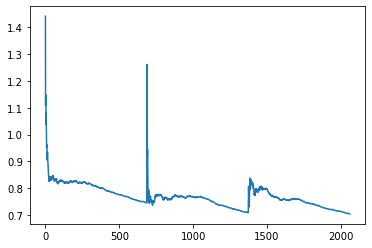

fold = 0 , epoch = 3 , jaccard = 0.702629


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.5min remaining:    0.0s


training ... batch 687 : train loss 0.771 



fold = 1 , epoch = 1 , jaccard = 0.710094


training ... batch 687 : train loss 0.729 


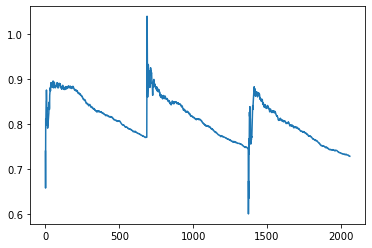

fold = 1 , epoch = 3 , jaccard = 0.711945


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 29.2min remaining:    0.0s


training ... batch 687 : train loss 0.777 



fold = 2 , epoch = 1 , jaccard = 0.708060


training ... batch 687 : train loss 0.574 


In [6]:
num_folds = 5
num_epochs = 1
batch_size = 32
learning_rate = 1e-2
num_train_steps = int(len(train_df) / batch_size * num_epochs)
num_warmup_steps = int(num_train_steps * 0.1)
pos_offsets = 1
best_score_list = []
    
data_df_5folds = generate_fold_data(train_df, 5)

def dataframe_stack_generate(pred_start1, pred_end1, text, selected_text, sentiment, offset, vaild_target_start, vaild_target_end, fold):
    dataframe_stack_train = pd.DataFrame({"pred_start": pred_start1.tolist(),
                                       "pred_end": pred_end1.tolist(),
                                       "text": text,
                                       "selected_text": selected_text,
                                       "sentiment": sentiment,
                                       "offset": offset.tolist(),
                                       "target_start": vaild_target_start.tolist(),
                                       "target_end": vaild_target_end.tolist(),
                                       "fold": [fold] * len(pred_start1)})
    return dataframe_stack_train

def run_first_stack(fold, dataframe_stack_train1, dataframe_stack_train2):
    df_train_fold = data_df_5folds[data_df_5folds.kfold != fold].reset_index(drop=True)
    df_valid_fold = data_df_5folds[data_df_5folds.kfold == fold].reset_index(drop=True)
    
    num_train_batches = len(df_train_fold) // batch_size + int(len(df_train_fold) % batch_size != 0)
    num_eval_batches = len(df_valid_fold) // batch_size + int(len(df_valid_fold) % batch_size != 0)
    num_test_batches = len(test_df) // batch_size + int(len(test_df) % batch_size != 0)

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    # optimizer = tf.keras.mixed_precision.experimental.LossScaleOptimizer(
    #     optimizer, 'dynamic')

    config = RobertaConfig.from_json_file(os.path.join(PATH, "config-roberta-base.json"))
    config.output_hidden_states = True
    config.num_labels = 2
    model1 = RoBertQAModel1.from_pretrained(os.path.join(PATH, "pretrained-roberta-base.h5"), config=config)
    model1.load_weights(f'../input/roberta-dropout02-adversarial/fold-{fold}.h5')
    
    model2 = RoBertQAModel2.from_pretrained(os.path.join(PATH, "pretrained-roberta-base.h5"), config=config)
    model2.load_weights(f'../input/tf-roberta-base/fold-{fold}.h5')
    
    model3 = RoBertQAModel3.from_pretrained(os.path.join(PATH, "pretrained-roberta-base.h5"), config=config)
    model3.load_weights(f'../input/tf-adversarial-training2/fold-{fold}.h5')
    
    model4 = RoBertQAModel4.from_pretrained(os.path.join(PATH, "pretrained-roberta-base.h5"), config=config)
    model4.load_weights(f'../input/tf-roberta-base-768/fold-{fold}.h5')
    
    model5 = RoBertQAModel5.from_pretrained(os.path.join(PATH, "pretrained-roberta-base.h5"), config=config)
    model5.load_weights(f'../input/tf-roberta-base-three/fold-{fold}.h5')
    
    model6 = RoBertQAModel1.from_pretrained(os.path.join(PATH, "pretrained-roberta-base.h5"), config=config)
    model6.load_weights(f'../input/tf-roberta-base-715/fold-{fold}.h5')
    
    # model7 = RoBertQAModel2.from_pretrained(os.path.join(PATH, "pretrained-roberta-base.h5"), config=config)
    # model7.load_weights(f'../input/tf-roberta-base-01/fold-{fold}.h5')
    
    loss_fn = focal_loss

    loss_step = []
    global_step = tf.Variable(0, name="global_step")
    # train_dataset = TweetSentimentDataset.create(
    #     df_train_fold, batch_size, shuffle_buffer_size=2048)
    valid_dataset = TweetSentimentDataset.create(
        df_valid_fold, batch_size, shuffle_buffer_size=-1)
    test_dataset = TweetSentimentDataset.create(
        test_df, batch_size, shuffle_buffer_size=-1)

    pred_start1, pred_end1, text, selected_text, sentiment, offset, vaild_target_start, vaild_target_end = \
        predict1(model1, valid_dataset, loss_fn, optimizer, num_eval_batches, fold)
    pred_start2, pred_end2, _, _, _, _ = \
        predict2(model2, valid_dataset, loss_fn, optimizer, num_eval_batches, fold)
    pred_start3, pred_end3, _, _, _, _, _, _ = \
        predict1(model3, valid_dataset, loss_fn, optimizer, num_eval_batches, fold)
    pred_start4, pred_end4, _, _, _, _ = \
        predict2(model4, valid_dataset, loss_fn, optimizer, num_eval_batches, fold)
    pred_start5, pred_end5, _, _, _, _ = \
        predict2(model5, valid_dataset, loss_fn, optimizer, num_eval_batches, fold)
    pred_start6, pred_end6, _, _, _, _, _, _ = \
        predict1(model6, valid_dataset, loss_fn, optimizer, num_eval_batches, fold)
    # pred_start7, pred_end7, _, _, _, _ = \
    #     predict2(model7, valid_dataset, loss_fn, optimizer, num_eval_batches, fold)
    
    pred_start1 += pred_start2 + pred_start3 + pred_start4 + pred_start5 + pred_start6 + pred_start7
    pred_end1 += pred_end2 + pred_end3 + pred_end4 + pred_end5 + pred_end6 + pred_end7
    pred_start1 = pred_start1 / 7
    pred_end1 = pred_end1 / 7
    
    if dataframe_stack_train1 is None:
        dataframe_stack_train1 = dataframe_stack_generate(pred_start1, pred_end1, text, selected_text, sentiment, offset, vaild_target_start, vaild_target_end, fold)
        dataframe_stack_train2 = dataframe_stack_generate(pred_start2, pred_end2, text, selected_text, sentiment, offset, vaild_target_start, vaild_target_end, fold)
    else:
        _dataframe_stack_train1 = dataframe_stack_generate(pred_start1, pred_end1, text, selected_text, sentiment, offset, vaild_target_start, vaild_target_end, fold)
        _dataframe_stack_train2 = dataframe_stack_generate(pred_start2, pred_end2, text, selected_text, sentiment, offset, vaild_target_start, vaild_target_end, fold)
        dataframe_stack_train1 = pd.concat([dataframe_stack_train1, _dataframe_stack_train1], axis=0)
        dataframe_stack_train2 = pd.concat([dataframe_stack_train2, _dataframe_stack_train2], axis=0)
        
    test_pred_start1, test_pred_end1, test_text, _, test_sentiment, test_offset, test_target_start, test_target_end = \
            predict1(model1, test_dataset, loss_fn, optimizer, num_test_batches, fold)
    test_pred_start2, test_pred_end2, _, _, _, _ = \
            predict2(model2, test_dataset, loss_fn, optimizer, num_test_batches, fold)
    test_pred_start3, test_pred_end3, _, _, _, _, _, _ = \
            predict1(model3, test_dataset, loss_fn, optimizer, num_test_batches, fold)
    test_pred_start4, test_pred_end4, _, _, _, _ = \
            predict2(model4, test_dataset, loss_fn, optimizer, num_test_batches, fold)
    test_pred_start5, test_pred_end5, _, _, _, _ = \
            predict2(model5, test_dataset, loss_fn, optimizer, num_test_batches, fold)
    test_pred_start6, test_pred_end6, _, _, _, _, _, _ = \
            predict1(model6, test_dataset, loss_fn, optimizer, num_test_batches, fold)
    test_pred_start7, test_pred_end7, _, _, _, _ = \
            predict2(model7, test_dataset, loss_fn, optimizer, num_test_batches, fold)

    test_pred_start1 += test_pred_start2 + test_pred_start3 + test_pred_start4 + test_pred_start5 + test_pred_start6 + test_pred_start7
    test_pred_end1 += test_pred_end2 + test_pred_end3 + test_pred_end4 + test_pred_end5 + test_pred_end6 + test_pred_end7
    test_pred_start1 = test_pred_start1 / 7
    test_pred_end1 = test_pred_end1 / 7
    
    return dataframe_stack_train1, dataframe_stack_train2, test_pred_start1, test_pred_end1, test_text, test_sentiment, test_offset, test_target_start, test_target_end


dataframe_stack_train1 = None
dataframe_stack_train2 = None

# initialize first test predictions
test_preds_start = np.zeros((len(test_df), MAX_SEQUENCE_LENGTH), dtype=np.float32)
test_preds_end = np.zeros((len(test_df), MAX_SEQUENCE_LENGTH), dtype=np.float32)

for i in range(5):
    dataframe_stack_train1, dataframe_stack_train2, test_pred_start, test_pred_end, test_text, test_sentiment, \
        test_offset, test_target_start, test_target_end = run_first_stack(i, dataframe_stack_train1, dataframe_stack_train2)

    test_preds_start += test_pred_start
    test_preds_end += test_pred_end
    
test_preds_start = test_preds_start / 5
test_preds_end = test_preds_end / 5

In [ ]:
def run_second_stack(test_preds_start, test_preds_end, test_text, test_sentiment, test_offset, test_target_start, test_target_end):
    
    dataframe_stack_test = dataframe_stack_generate(test_preds_start, test_preds_end, test_text, test_text, test_sentiment, test_offset, test_target_start, test_target_end, 0)
    
    # initialize second test predictions
    test_preds_start = np.zeros((len(test_df), MAX_SEQUENCE_LENGTH), dtype=np.float32)
    test_preds_end = np.zeros((len(test_df), MAX_SEQUENCE_LENGTH), dtype=np.float32)
    
    # second train
    for fold in range(num_folds):
        dataframe_stack_data1_train = dataframe_stack_train1[dataframe_stack_train1.fold != fold].reset_index(drop=True)
        # dataframe_stack_data2_train = dataframe_stack_train2[dataframe_stack_train2.fold != fold].reset_index(drop=True)
        dataframe_stack_data1_vaild = dataframe_stack_train1[dataframe_stack_train1.fold == fold].reset_index(drop=True)
        
        num_train_batches = len(dataframe_stack_data1_train) // batch_size + int(len(dataframe_stack_data1_train) % batch_size != 0)
        num_eval_batches = len(dataframe_stack_data1_vaild) // batch_size + int(len(dataframe_stack_data1_vaild) % batch_size != 0)
        num_test_batches = len(dataframe_stack_test) // batch_size + int(len(dataframe_stack_test) % batch_size != 0)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        loss_fn = focal_loss
        
        # model 
        model = StackingDnn()
        
        loss_step = []
        global_step = tf.Variable(0, name="global_step")
        
        train_dataset1 = StackingDataset.create(
            dataframe_stack_data1_train, batch_size, shuffle_buffer_size=2048)
        # train_dataset2 = StackingDataset.create(
        #     dataframe_stack_data2_train, batch_size, shuffle_buffer_size=2048)
        valid_dataset = StackingDataset.create(
            dataframe_stack_data1_vaild, batch_size, shuffle_buffer_size=-1)
        test_dataset = StackingDataset.create(
            dataframe_stack_test, batch_size, shuffle_buffer_size=-1)
        
        best_score = float('-inf')
        for epoch_num in range(num_epochs):
            # train for an epoch
            stacking_train(model, train_dataset1, loss_fn, optimizer, global_step, loss_step, num_train_batches, fold)
            # stacking_train(model, train_dataset2, loss_fn, optimizer, global_step, loss_step, num_train_batches, fold)
    
            # predict validation set and compute jaccardian distances
            pred_start, pred_end, text, selected_text, sentiment, offset = \
                stacking_predict(model, valid_dataset, loss_fn, optimizer, num_eval_batches, fold)

            selected_text_pred = decode_prediction(pred_start, pred_end, text, offset, sentiment, is_testing=False)
            jaccards = []
            for i in range(len(selected_text)):
                jaccards.append(
                    jaccard(selected_text[i], selected_text_pred[i]))
    
            score = np.mean(jaccards)
    
            if epoch_num + 1 == num_epochs:
                plt.plot(list(range(global_step.numpy())), loss_step)
                plt.show()
            print("fold = %d , epoch = %d , jaccard = %f" % (fold, epoch_num+1, score))
    
            if score > best_score:
                best_score = score
                model.save_weights(f'fold-{fold}.h5')
    
                # predict test set
                test_pred_start, test_pred_end, test_text, _, test_sentiment, test_offset = \
                    stacking_predict(model, test_dataset, loss_fn, optimizer, num_test_batches, fold)
            
        best_score_list.append(best_score)
        # add epoch's best test preds to test preds arrays
        test_preds_start += test_pred_start
        test_preds_end += test_pred_end

        # reset model, as well as session and graph (to avoid OOM issues?) 
        session = tf.compat.v1.get_default_session()
        graph = tf.compat.v1.get_default_graph()
        del session, graph, model
        model = StackingDnn()
    return (test_preds_start, test_preds_end, test_text, test_sentiment, test_offset)
        
(test_preds_start, test_preds_end, test_text, test_sentiment, test_offset) = \
    run_second_stack(test_preds_start, test_preds_end, test_text, test_sentiment, test_offset, test_target_start, test_target_end)

with open("result.txt", "w") as f:
    f.write("average jaccard:")
    f.write(str(np.mean(best_score_list)) + "\n")
    for score in best_score_list:
        f.write(str(score) + "\n")

selected_text_pred = decode_prediction(
    test_preds_start, test_preds_end, test_text, test_offset, test_sentiment, is_testing=True)

submission_df.loc[:, 'selected_text'] = selected_text_pred
submission_df['selected_text'] = submission_df['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
submission_df['selected_text'] = submission_df['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
submission_df['selected_text'] = submission_df['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
submission_df['selected_text'] = submission_df.apply(lambda x: post_process(x['selected_text']) if (len(str(x['selected_text']).split())==1) else x['selected_text'], axis=1)
submission_df.to_csv("submission.csv", index=False)